# A/B Hypothesis Testing on the Northwind Traders Database

* Lucas Kelly

* https://lucaskellydataportfolio.weebly.com/flatiron-blog/ab-hypothesis-testing-on-the-northwind-traders-database

* June, 2019

# Introduction

Using the database as described in the ERD below, this notebook showcases 5 questions that are tested and answered various using statistical tests. Each question highlighted in the Outline is broken down into a null and alternative hypothesis. In addition, each question follows the scientific process of asking a question, generating a hypothesis, collecting information, experimenting, analyzing the results and coming to conclusion (whether to accept or reject the null hypothesis. The questions are also divided into relevant business topics such as sales and profits, customer relationship and employee productivity. For a detailed approach and methodology for one of these questions, see the blog entry linked above.

# Outline

### Question 1.1 (Sales): 
Do discounts have a statistically significant effect on the number of products customers order?
    - Hypothesis:
        * Null - Discounts do not have a significant effect on the number of products customers order.
        * Alternative - Discounts do have a statistically significant effect on the number of products customers order. 
    - Data
    - Experiment:
        - One-sample T-test, Cohen's d
    - Analysis
        - T-value = 7.52
        - Critical t-value = 1.647
        - P-value = 0.0
        - Cohen's d = 0.2862724481729283 (medium effect)
    - Conclusion
        - Rejection of the null.
        - Discounts do have an impact on the quantity of the sale.
###### -------------------------------------------------------------------------------------------------------------------------------------
### Question 1.2 (Sales): 
What level(s) of discounts are most effective in increasing quantity?
    - Hypothesis:
        * Null - The level of discount does not have an effect on the quantity of items in the order.
        * Alternative - The level of discount does have an effect on the quantity of the items in the order.
    - Data
    - Experiment:
        - ANOVA test
    - Analysis
        - %5 discount has the biggest impact on quantity, 10% the least impact on quantity
    - Conclusion
        - Rejection of the null.
###### -------------------------------------------------------------------------------------------------------------------------------------
### Question 2 (Employees): 
Are there any significant differences in the average dollar amount of individual sales amongst employees?
    - Hypothesis: 
        * Null - There are no significant differences in average sales amounts amoung employees.
        * Alternative - There are statistically significant differences in the sales amounts generated among                 employees. 
    - Data
    - Experiment:
        - Kruskal-Wallis H-test
    - Analysis:
        - Stat - 10.511
        - P value 0.231 greater than alpha
    - Conclusion:
        - Fail to reject the null. 
###### -------------------------------------------------------------------------------------------------------------------------------------
### Question 3 (Customers): 
Are any regions in Europe underperforming in customer sales?
    - Hypothesis:
        * Null - There are no significant differences in sales amoung employees.
        * Alternative - There are statistically significant differences in the amount of sales generated among                 employees.
    - Data
    - Experiment:
        - Two sample T-test
    - Analysis:
        - Though Western Europe is clearly generating more business, there is no clear difference in average sales prices between european regions
    - Conclusion:
        - Fail to reject the null.
###### -------------------------------------------------------------------------------------------------------------------------------------
### Question 4 (Employees): 
Do employees covering more regions sell more products?
    - Hypothesis:
        * Null - There are no significant differences in quantity of sales between employees with a higher number of sales territories.
        * Alternative - There are statistically significant differences in quantity of sales generated among                 employees with higher territories.
    - Data
    - Experiment:
        - Two sample T-test, Cohen's d
    - Analysis:
        - T Stat = (-6.960)
        - p = 0.000
        - Cohen's d =  0.13831462752761897 (small effect)
    - Conclusion
        - Rejection of the null. 
###### -------------------------------------------------------------------------------------------------------------------------------------
### Question 5.1 (Products and Service to Customers): 
Are there any product categories that go on backorder more than average?
    - Hypothesis:
        * Null - There are no significant differences in sales amoung employees.
        * Alternative - There are statistically significant differences in the amount of sales generated among                 employees.
    - Data
    - Experiment: 
        - Test1: Kruskall-Wallis H-test
        - Test2: 2 Sample T-test
    - Analysis:
        - Test1: Reject the null. 
        - Test2: Fail to reject the null.
    - Conclusion
        - Product category on backorder does vary by category, but no one category shows higher units on backorder than the average.
###### -------------------------------------------------------------------------------------------------------------------------------------
### Question 5.2 (Products and Service to Customers): 
Are there any product categories that go on backorder more than average?
    - Hypothesis:
        * Null - There are no significant differences in sales amoung employees.
        * Alternative - There are statistically significant differences in the amount of sales generated among                 employees.
    - Data
    - Experiment:
        - Mann-Whitney U test
    - Analysis:
        - Statistics=512383.000, p=0.208
        - Same distribution (fail to reject H0)
    - Conclusion
        - Items on backorder do not take longer to process than items in stock.
###### -------------------------------------------------------------------------------------------------------------------------------------
###### -------------------------------------------------------------------------------------------------------------------------------------

## Northwind Traders Database ERD

![alt text](Northwind_ERD.png "Title")

# Libraries

In [1258]:
# Loading requried libraries

# SQL 
import sqlite3
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy import inspect
from sqlalchemy.orm import Session, sessionmaker

# Analytical Tools
import pandas as pd # for dataframe
import numpy as np # analysis
from scipy import stats # significance levels, normality
import itertools # for combinations
import statsmodels.api as sm # anova
from statsmodels.formula.api import ols
import math
from scipy.stats import kruskal
from scipy.stats import mannwhitneyu

# Visualizations
import matplotlib.pyplot as plt # plotting
import seaborn as sns # plotting
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.factorplots import interaction_plot

import warnings
warnings.filterwarnings('ignore') # hide matplotlib warnings

# Functions

In [1359]:
# Function to visualize and compare two distributions

def visualization(control, experimental):
    plt.figure(figsize=[10,6])
    sns.distplot(control, color='blue', label='Control', bins = 50)
    plt.axvline(control.mean(), color='darkblue', label='Control Mean')
    sns.distplot(experimental, color='green', label='Experimental', bins = 50)
    plt.axvline(experimental.mean(), color='darkgreen', label='Experimental Mean')
    plt.legend()
    plt.title('Control vs. Experimental')
    plt.xlabel('Distribution')
    plt.ylabel('Frequency')
    plt.show()

In [1360]:
# Funtion to check a single distribution's normality

def normal_visualization1(distribution):
    fig, axes = plt.subplots(1,2, figsize=[15,7])

    sns.distplot(distribution, bins = 10, ax=axes[0])
    sns.set(color_codes=True)
    sns.set(rc={'figure.figsize':(8,6)})

    qqplot(distribution, line='s', ax=axes[1])

    plt.show()

In [1371]:
# Funtion to check a two distribution's normality at once

def normal_visualization2(control, experimental):
    fig, axes = plt.subplots(2,1, figsize=[20,12])

    qqplot(experimental, line='s', ax=axes[0])
    axes[0].set_title('Experimental')
    
    qqplot(control, line='s', ax=axes[1])
    axes[1].set_title('Control')

    plt.show()

In [1362]:
# Function to clean up the table names

def get_columns_info(col_name):
    cols_list = inspector.get_columns(col_name)
    
    print("Table Name: {}".format(col_name))
    print("")
    
    for column in cols_list:
        print("Name: {} \t Type: {}".format(column['name'], column['type']))

In [1363]:
# Funtion to calculate cohen's d statistic

def Cohen_d(group1, group2):

    diff = group1.mean() - group2.mean()
    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()
    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    print("Cohen's d = ", abs(d))
    if (abs(d))<0.2:
        print('Small Effect')
    if 0.2 < (abs(d)) <= 0.5:
        print('Medium Effect')
    if (abs(d)) > 0.5:
        print('Large Effect')
    

In [1364]:
# Function to calculate a one sample t-test

def one_sample_ttest(sample, mu, alpha):

    # Population mean 
    mu = np.mean(control)
    
    # Sample mean (x̄) using NumPy mean()
    x_bar= np.mean(experimental)

    # Sample Stadrad Deviation (sigma) using Numpy
    sigma = np.std(experimental)
    
    # Degrees of freedom
    freedom = len(experimental) - 1
    
    #Calculate the critical t-value
    t_crit = stats.t.ppf(1 - alpha, df=freedom)
    
    #Calculate the t-value and p-value
    results = stats.ttest_1samp(a= experimental, popmean= mu)         
    
    if (results[0]>t_crit) and (results[1]<alpha):
        print('T-value =', round(results[0], 2))
        print('Critical t-value =', np.round(t_crit, 3)) 
        print('P-value =', np.round((results[1]), 10))
        print ('Null hypothesis rejected.')
    else:
        print('T-value =', round(results[0], 2))
        print('Critical t-value =', np.round(t_crit, 3)) 
        print('P-value =', np.round((results[1]), 10))
        print ('Null hypothesis is accepted.')

## Question 1.1: 

Do discounts have a statistically significant effect on the number of products customers order?

## Hypothesis 1.1:

#### Null:

Discounts do not have a significant effect on the number of products customers order.

#### Alternative:

Discounts do have a statistically significant effect on the number of products customers order. 

## Data 1.1:

Collecting data using SQL to create a control group of sales that do not contain a discount and a experimental group that does apply a discount. 

In [1365]:
# View all table names

engine = create_engine("sqlite:///Northwind_small.sqlite", echo=True)
Session = sessionmaker(bind=engine)
session = Session()

con = engine.connect()
inspector = inspect(engine)
print(inspector.get_table_names())

2019-06-07 05:50:00,929 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1


INFO:sqlalchemy.engine.base.Engine:SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1


2019-06-07 05:50:00,952 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


2019-06-07 05:50:00,979 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1


INFO:sqlalchemy.engine.base.Engine:SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1


2019-06-07 05:50:00,984 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


2019-06-07 05:50:01,153 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name


INFO:sqlalchemy.engine.base.Engine:SELECT name FROM sqlite_master WHERE type='table' ORDER BY name


2019-06-07 05:50:01,160 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


['Category', 'Customer', 'CustomerCustomerDemo', 'CustomerDemographic', 'Employee', 'EmployeeTerritory', 'Order', 'OrderDetail', 'Product', 'Region', 'Shipper', 'Supplier', 'Territory']


In [1366]:
# Pulling data with SQL and converting to pandas dataframe

# Table should include everything from the OrderDetail table

rs = con.execute("SELECT * from OrderDetail")
columns = ['Id', 'OrderId', 'ProductId', 'UnitPrice', 'Quantity', 'Discount']
dfq1 = pd.DataFrame(rs.fetchall(), columns = columns)
dfq1.head()

2019-06-07 05:50:50,621 INFO sqlalchemy.engine.base.Engine SELECT * from OrderDetail


INFO:sqlalchemy.engine.base.Engine:SELECT * from OrderDetail


2019-06-07 05:50:50,623 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [1367]:
# Set two groups to compare

controlq1 = dfq1[dfq1['Discount']==0]['Quantity']
experimentalq1 = dfq1[dfq1['Discount']!=0]['Quantity']

Text(0.5, 1.0, 'Discount v.s. No Discount Average Quantity of Product Per Order')

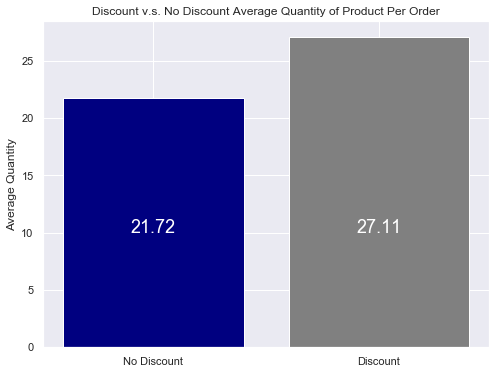

In [1368]:
# Visualize the difference between the averages of the control and the mean

X = ['No Discount', 'Discount', ]
y = [controlq1.mean(), experimentalq1.mean()]
plt.bar(X,y, color=('navy','grey'))
plt.text(s=round(y[1],2), x=1, y=10, color="w", horizontalalignment='center',size=18)
plt.text(s=round(y[0],2), x=0, y=10, color="w", horizontalalignment='center',size=18)
plt.ylabel('Average Quantity')
plt.title('Discount v.s. No Discount Average Quantity of Product Per Order')

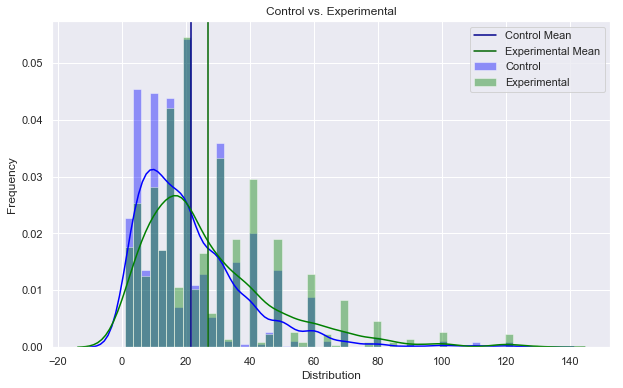

In [1369]:
# Compare distributions

visualization(controlq1, experimentalq1)

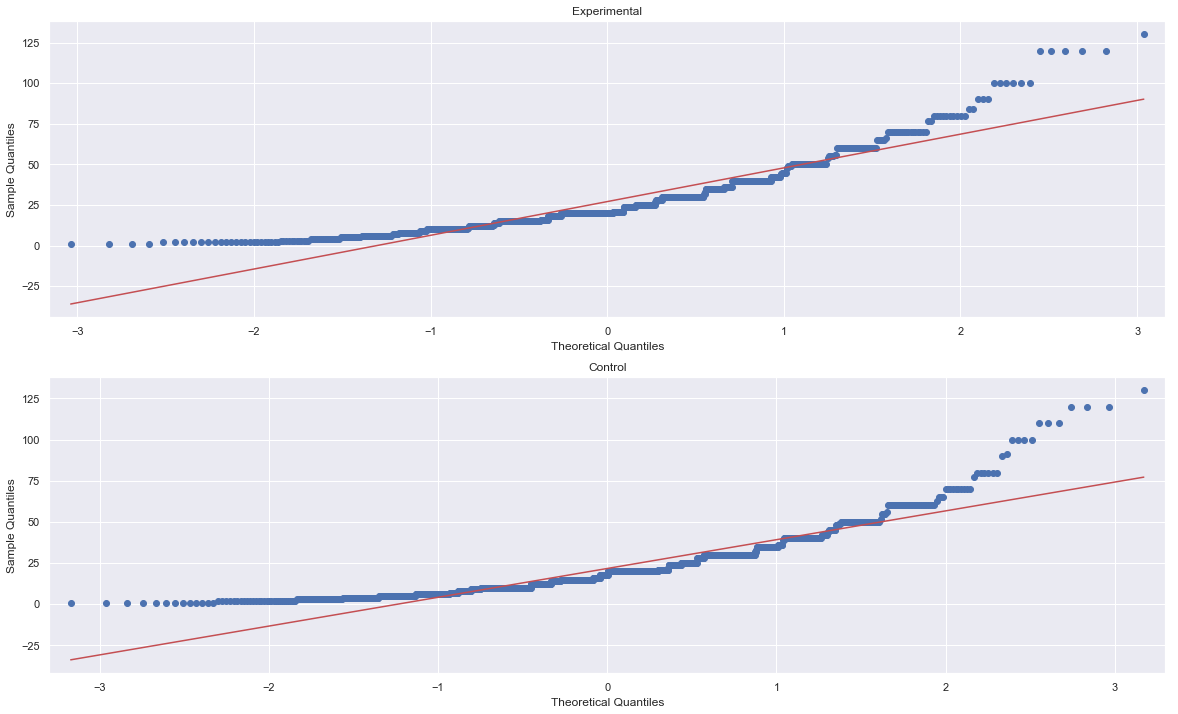

In [1372]:
# Check to see if distributions are normal

normal_visualization2(controlq1, experimentalq1)

## Experiment 1.1: 

Given the distributions are mostly normal, this test will use a one sample t-test and compare it to a t-critical value to determine whether or not the quantity of sales with a discount is significantly higher (alternative) than sales without a discount (null).

In [1373]:
# Calculate t-test

one_sample_ttest(experimental, mu, 0.05)

T-value = 7.52
Critical t-value = 1.647
P-value = 0.0
Null hypothesis rejected.


In [1374]:
# Check the effect size

Cohen_d(experimental, control)

Cohen's d =  0.2862724481729283
Medium Effect


## Analysis 1.1:

- With a T-value greater than our Critical T-value and a P value less than the alpha, we reject the null hypothesis. 

- We can see that discount level has a medium effect on the quantity of the sale. 


## Conclusion 1.1:

Based on the results of this experiment, we can reject the null hypothesis and conclude that discounts do have a statistically significant effect on the number of products customers order. 

# -----------------------------------------------------------------------------------------

## Question 1.2: 

What level(s) of discounts are most effective in increasing quantity?

## Hypothesis 1.2:

#### Null:

The level of discount does not have an effect on the quantity of items in the order.

#### Alternative:

The level of discount does have an effect on the quantity of the items in the order. 

## Data 1.2:

Using the same data frame, we will look at the various levels of discount and how many items were sold.

In [1272]:
# Find all discount levels

discounts = dfq1['Discount'].unique()
discounts.sort()
print('Discount levels')
print(discounts)

# Group orders by discount amounts

# Each group is a DataFrame containing orders with certain discount level
groups = {}
for i in discounts:
    groups[i] = dfq1[dfq1['Discount']==i]

# Create new DataFrame with Discounts and Order quantities
discounts_df = pd.DataFrame(columns=['Discount %','Orders','Avg. Order Quantity'])
for i in groups.keys():
    discounts_df = discounts_df.append({'Discount %':i*100,'Orders':len(groups[i]),'Avg. Order Quantity':groups[i]['Quantity'].mean()}, ignore_index=True)

discounts_df 


Discount levels
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.1  0.15 0.2  0.25]


,Discount %,Orders,Avg. Order Quantity
0,0.0,1317.0,21.715262
1,1.0,1.0,2.000000
2,2.0,2.0,2.000000
3,3.0,3.0,1.666667
4,4.0,1.0,1.000000
5,5.0,185.0,28.010811
6,6.0,1.0,2.000000
7,10.0,173.0,25.236994
8,15.0,157.0,28.382166
9,20.0,161.0,27.024845


In [1382]:
# Only discount levels of 5, 10, 15, 20 and 25 have enough orders to test. 

# Breaking down those individual discount levels and comparing them to the quantities they average.

y1 = controlq1.mean()
y2 = experimentalq1.mean()
y3 = np.mean(discounts_df[discounts_df['Discount %']==5.0]['Avg. Order Quantity'])
y4 = np.mean(discounts_df[discounts_df['Discount %']==10.0]['Avg. Order Quantity'])
y5 = np.mean(discounts_df[discounts_df['Discount %']==15.0]['Avg. Order Quantity'])
y6 = np.mean(discounts_df[discounts_df['Discount %']==20.0]['Avg. Order Quantity'])
y7 = np.mean(discounts_df[discounts_df['Discount %']==25.0]['Avg. Order Quantity'])

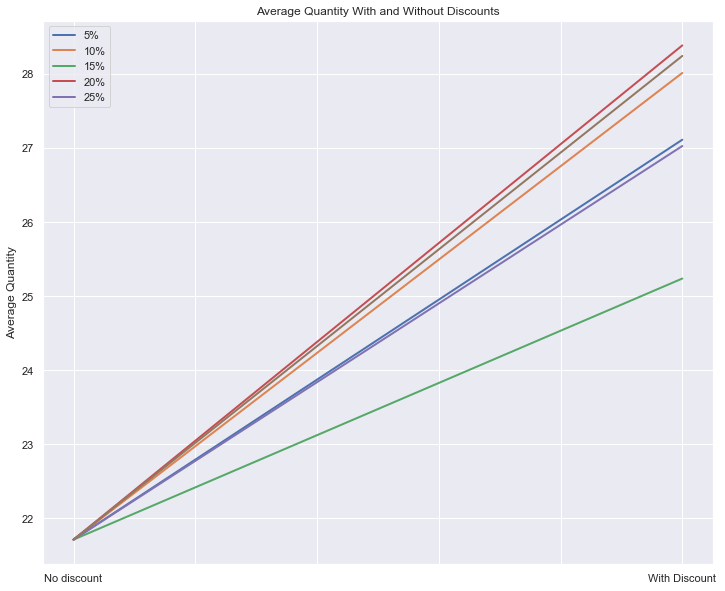

In [1383]:
# Visualization showing the change in average quantity with discounts compared to without

plt.figure(figsize=(12,10))
plt.plot([0, 5], [y1, y2], linewidth=2.0)
plt.plot([0, 5], [y1, y3], linewidth=2.0)
plt.plot([0, 5], [y1, y4], linewidth=2.0)
plt.plot([0, 5], [y1, y5], linewidth=2.0)
plt.plot([0, 5], [y1, y6], linewidth=2.0)
plt.plot([0, 5], [y1, y7], linewidth=2.0)
plt.xticks(np.arange(6), ('No discount', '', '', '', '', 'With Discount'))
plt.title('Average Quantity With and Without Discounts')
plt.ylabel('Average Quantity')
plt.legend(['5%', '10%', '15%', '20%', '25%'], loc='upper left')
plt.show()

In [1384]:
# An ANOVA test will be a great way to compare discount levels and their effect on quantity. 

# In order to set up for the test, convert each discount level to a categorical

discounts = df['Discount'].tolist()
quantities = df['Quantity'].tolist()
disc5 = []
disc10 = []
disc15 = []
disc20 = []
disc25 = []

for i in discounts:
    if i == 0.05:
        disc5.append(1)
    else:
        disc5.append(0)

for i in discounts:
    if i == 0.10:
        disc10.append(1)
    else:
        disc10.append(0)
        
for i in discounts:
    if i == 0.15:
        disc15.append(1)
    else:
        disc15.append(0)
    
for i in discounts:
    if i == 0.20:
        disc20.append(1)
    else:
        disc20.append(0)

for i in discounts:
    if i == 0.25:
        disc25.append(1)
    else:
        disc25.append(0)

ANOVA_discounts = pd.DataFrame({'Quantity' : quantities,
                                'five' : disc5, 'ten' : disc10, 'fifteen' : disc15, 'twenty' : disc20, 'twentyfive' : disc25})

In [1385]:
ANOVA_discounts.head()

,Quantity,five,ten,fifteen,twenty,twentyfive
0,12,0,0,0,0,0
1,10,0,0,0,0,0
2,5,0,0,0,0,0
3,9,0,0,0,0,0
4,40,0,0,0,0,0


## Experiment 1.2:

In [1386]:
# Use ANOVA test to determine the impact of discounts by level to quantity

formula = 'Quantity ~ C(five) + C(ten) + C(fifteen) + C(twenty) + C(twentyfive)'
lm = ols(formula, ANOVA_discounts).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                      sum_sq      df          F    PR(>F)
C(five)          6682.701649     1.0  18.863661  0.000015
C(ten)           2030.000607     1.0   5.730204  0.016761
C(fifteen)       6466.666108     1.0  18.253844  0.000020
C(twenty)        4232.949011     1.0  11.948598  0.000558
C(twentyfive)    6092.974191     1.0  17.199002  0.000035
Residual       761311.705709  2149.0        NaN       NaN


## Analysis 1.2:

- Each discount level shows significant influence on quantity as each PR(>F) value is below our 0.05 alpha level
- A discount level of 5% has the most significant impact on quantity
- A discount level of 15% has the second most significant impact on quantity
- A discount level of 10% has the least significant impact on quantity

## Conclusion 1.2:

Given the results of this experiment, we reject the null hypothesis and accept that the level of discount does have an effect on the quantity of the items in the order. 

# -----------------------------------------------------------------------------------------

## Question 2:

Are any employees averaging a higher sales price per sale than others?

## Hypothesis 2:

#### Null:

There are no significant differences in individual sales prices amoung employees.

#### Alternative:

There are statistically significant differences in individual sales prices amoung employees. 

## Data 2:

In [1389]:
# Generate df with needed data

cur.execute("""SELECT OD.unitprice, OD.quantity, E.birthdate, E.Id, E.LastName FROM Employee as E
                        join [Order] as O 
                        on E.Id = O.EmployeeId
                        join [OrderDetail] as OD
                        on OD.OrderId = O.Id;
                        """)

dfq2 = pd.DataFrame(cur.fetchall())
dfq2.columns = [i[0] for i in cur.description]
dfq2['Total_Sale'] = dfq2['UnitPrice'] * dfq2['Quantity']
dfq2.head()

,UnitPrice,Quantity,BirthDate,Id,LastName,Total_Sale
0,14.0,12,1987-03-04,5,Buchanan,168.0
1,9.8,10,1987-03-04,5,Buchanan,98.0
2,34.8,5,1987-03-04,5,Buchanan,174.0
3,18.6,9,1995-07-02,6,Suyama,167.4
4,42.4,40,1995-07-02,6,Suyama,1696.0


In [1390]:
# Calculate the employee's average sales amount

eavg = np.mean(dfq2['Total_Sale'])
eavg

628.5190672853829

In [1391]:
# Find each employees name for visualization purposes

e1name = dfq2[dfq2['Id']==1]['LastName']
e2name = dfq2[dfq2['Id']==2]['LastName']
e3name = dfq2[dfq2['Id']==3]['LastName']
e4name = dfq2[dfq2['Id']==4]['LastName']
e5name = dfq2[dfq2['Id']==5]['LastName']
e6name = dfq2[dfq2['Id']==6]['LastName']
e7name = dfq2[dfq2['Id']==7]['LastName']
e8name = dfq2[dfq2['Id']==8]['LastName']
e9name = dfq2[dfq2['Id']==9]['LastName']

In [1392]:
# Find each individual employee's total sales amounts

e1 = dfq2[dfq2['Id']==1]['Total_Sale']
e2 = dfq2[dfq2['Id']==2]['Total_Sale']
e3 = dfq2[dfq2['Id']==3]['Total_Sale']
e4 = dfq2[dfq2['Id']==4]['Total_Sale']
e5 = dfq2[dfq2['Id']==5]['Total_Sale']
e6 = dfq2[dfq2['Id']==6]['Total_Sale']
e7 = dfq2[dfq2['Id']==7]['Total_Sale']
e8 = dfq2[dfq2['Id']==8]['Total_Sale']
e9 = dfq2[dfq2['Id']==9]['Total_Sale']

In [1393]:
# Create df of employee average sales

employee_avg_sales = {'Employee':[e1name.unique()[0], e2name.unique()[0], e3name.unique()[0], e4name.unique()[0], e5name.unique()[0], e6name.unique()[0], e7name.unique()[0], e8name.unique()[0], e9name.unique()[0]], 'Average Sales Price':[np.mean(e1),np.mean(e2),np.mean(e3),np.mean(e4),np.mean(e5),np.mean(e6),np.mean(e7),np.mean(e8),np.mean(e9)]}
employee_avg_sales_df = pd.DataFrame(employee_avg_sales)
employee_avg_sales_df


,Employee,Average Sales Price
0,Davolio,585.923797
1,Fuller,737.548797
2,Leverling,663.711215
3,Peacock,595.684405
4,Buchanan,645.878205
5,Suyama,465.464881
6,King,802.818125
7,Callahan,512.696269
8,Dodsworth,775.364486


<Figure size 576x432 with 0 Axes>

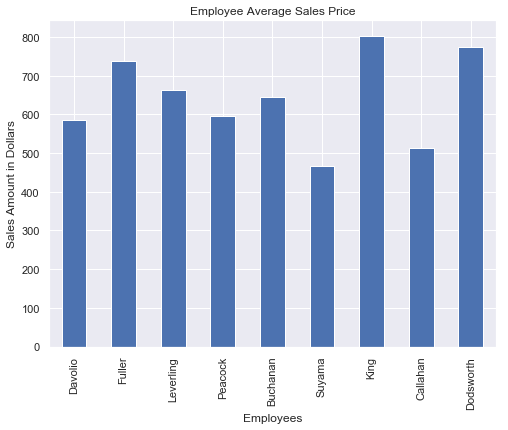

In [1394]:
# Visualize average sales amoung each employee

plt.figure(figsize=[8,6])
tester_df.plot(kind = 'bar', figsize = (8,6))
plt.title('Employee Average Sales Price')
plt.xlabel('Employees')
plt.ylabel('Sales Amount in Dollars')
plt.legend().set_visible(False)
plt.xticks(np.arange(9), (e1name.unique()[0], e2name.unique()[0], e3name.unique()[0], e4name.unique()[0], e5name.unique()[0], e6name.unique()[0], e7name.unique()[0], e8name.unique()[0], e9name.unique()[0]))
plt.show()


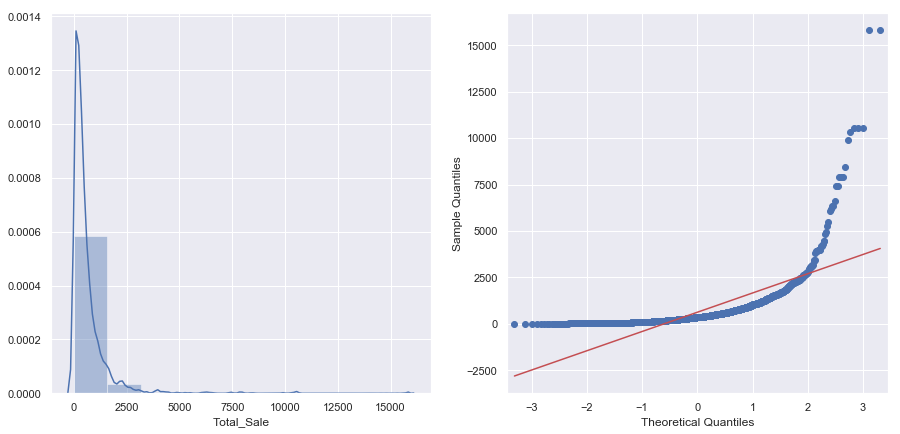

In [1395]:
# Check the normality of the distribution

normal_visualization1(dfq2['Total_Sale'])

## Experiment 2:

Given the non-normal distribution of total employee sales, this experiment will use a non-parametric test, the Kruskal Wallis H-test to determine if there is a significant different amoungst employees and their average total sales.

In [1396]:
stat, p = kruskal(e1, e2, e3, e4, e5, e6, e7, e8, e9)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

Statistics=10.511, p=0.231
Same distributions (fail to reject H0)


## Analysis 2:

- The H-test statistic of 10.511 shows a low difference between each employee's average sale. A larger value indicates larger differences. For our data it's roughly 10.511 and given our large sampling distribution we can see that it is a low difference. 

- P value of 0.231 is greater than the alpha level of 0.05 and therefore we fail to reject the null hypothesis.

## Conclusion 2:

Given the results of this experiment, we fail to reject the null hypothesis and accept that there are no significant differences in individual sales prices amoung employees.

# -----------------------------------------------------------------------------------------

## Question 3: 

Do any regions in Europe (N, E, S, W) have significantly lower than average sales prices?

## Hypothesis 3:

#### Null:

There are no significant differences in the average sales price among the European regions.

#### Alternative:

There are statistically significant differences in the average sales price among the European regions. 


## Data 3:

In [1397]:
# New SQL connection

conn = sqlite3.connect("Northwind_small.sqlite", detect_types=sqlite3.PARSE_COLNAMES)
cur = conn.cursor()

In [1398]:
# Pulling down necessary information

cur.execute("""SELECT * FROM [Order]
                        join Customer
                        on [Order].CustomerId = Customer.Id
                        join [OrderDetail]
                        on [OrderDetail].OrderId = [Order].Id""")

dfq3 = pd.DataFrame(cur.fetchall())
dfq3.columns = [i[0] for i in cur.description]
dfq3 = dfq3[['Id', 'City', 'Region', 'Country', 'OrderDate', 'UnitPrice', 'Quantity']]
dfq3['Total_Sale'] = dfq2['UnitPrice'] * dfq2['Quantity']
dfq3.head()

,Id,Id,Id,City,Region,Country,OrderDate,UnitPrice,Quantity,Total_Sale
0,10248,VINET,10248/11,Reims,Western Europe,France,2012-07-04,14.0,12,168.0
1,10248,VINET,10248/42,Reims,Western Europe,France,2012-07-04,9.8,10,98.0
2,10248,VINET,10248/72,Reims,Western Europe,France,2012-07-04,34.8,5,174.0
3,10249,TOMSP,10249/14,Münster,Western Europe,Germany,2012-07-05,18.6,9,167.4
4,10249,TOMSP,10249/51,Münster,Western Europe,Germany,2012-07-05,42.4,40,1696.0


In [1399]:
# Breaking down total sales by region

W = dfq3[dfq3['Region']=='Western Europe']['Total_Sale']
E = dfq3[dfq3['Region']=='Eastern Europe']['Total_Sale']
S = dfq3[dfq3['Region']=='Southern Europe']['Total_Sale']
N = dfq3[dfq3['Region']=='Northern Europe']['Total_Sale']

# Creating a control that shows total sales in Europe
controlq3 = pd.concat([W, E, S, N])
region_list = {'Western Europe':W, 'Eastern Europe':E, 'Southern Europe':S, 'Northern Europe':N}
region_list_sums = {'Western Europe':np.sum(W), 'Eastern Europe':np.sum(E), 'Southern Europe':np.sum(S), 'Northern Europe':np.sum(N)}
region_list_avg = {'Western Europe':np.mean(W), 'Eastern Europe':np.mean(E), 'Southern Europe':np.mean(S), 'Northern Europe':np.mean(N)}


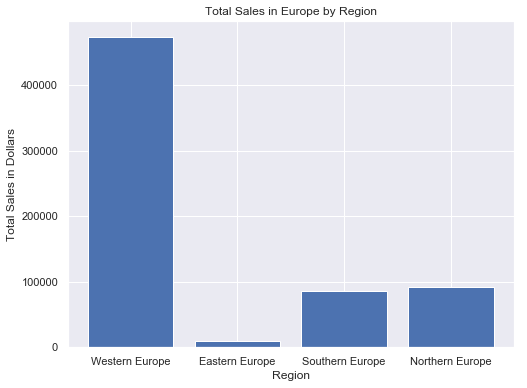

In [1402]:
# Visualize total sales by region

plt.figure(figsize = (8,6))
plt.bar(range(len(region_list_sums)), list(region_list_sums.values()), align='center')
plt.xticks(range(len(region_list_sums)), list(region_list_sums.keys()))
plt.title('Total Sales in Europe by Region')
plt.xlabel('Region')
plt.ylabel('Total Sales in Dollars')
#plt.show()

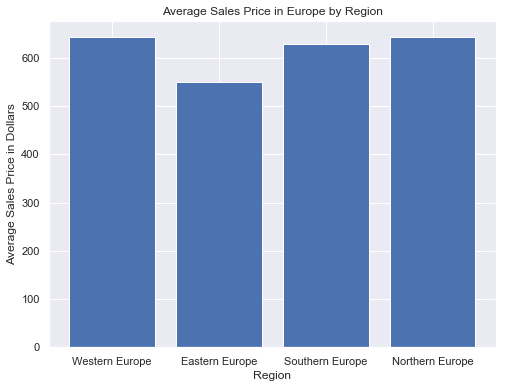

In [1403]:
# Visualize average sales price per sale

plt.figure(figsize = (8,6))
plt.bar(range(len(region_list_avg)), list(region_list_avg.values()), align='center')
plt.xticks(range(len(region_list_avg)), list(region_list_avg.keys()))
plt.title('Average Sales Price in Europe by Region')
plt.xlabel('Region')
plt.ylabel('Average Sales Price in Dollars')
plt.show()

Western Europe
Statistics=-0.086, p=0.932
Cohen's d =  0.004131925922895823
Small Effect
Same distributions (fail to reject H0)
---------------------------------------------


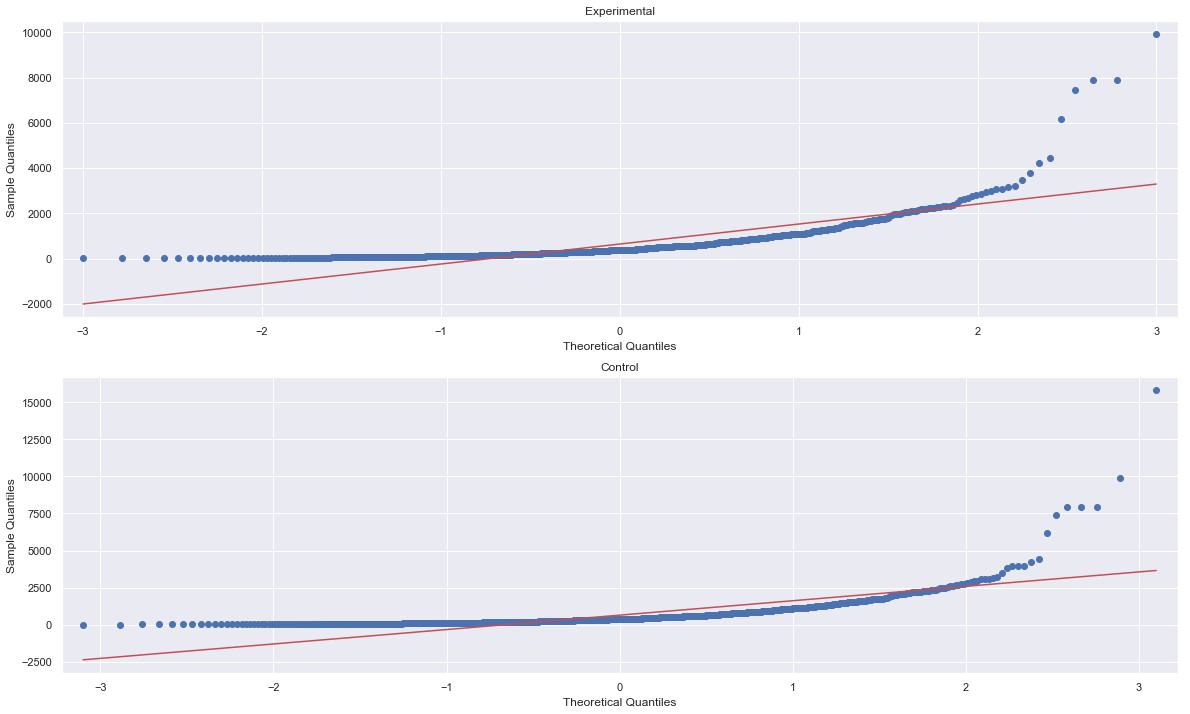

Eastern Europe
Statistics=0.372, p=0.710
Cohen's d =  0.09370232533228075
Small Effect
Same distributions (fail to reject H0)
---------------------------------------------


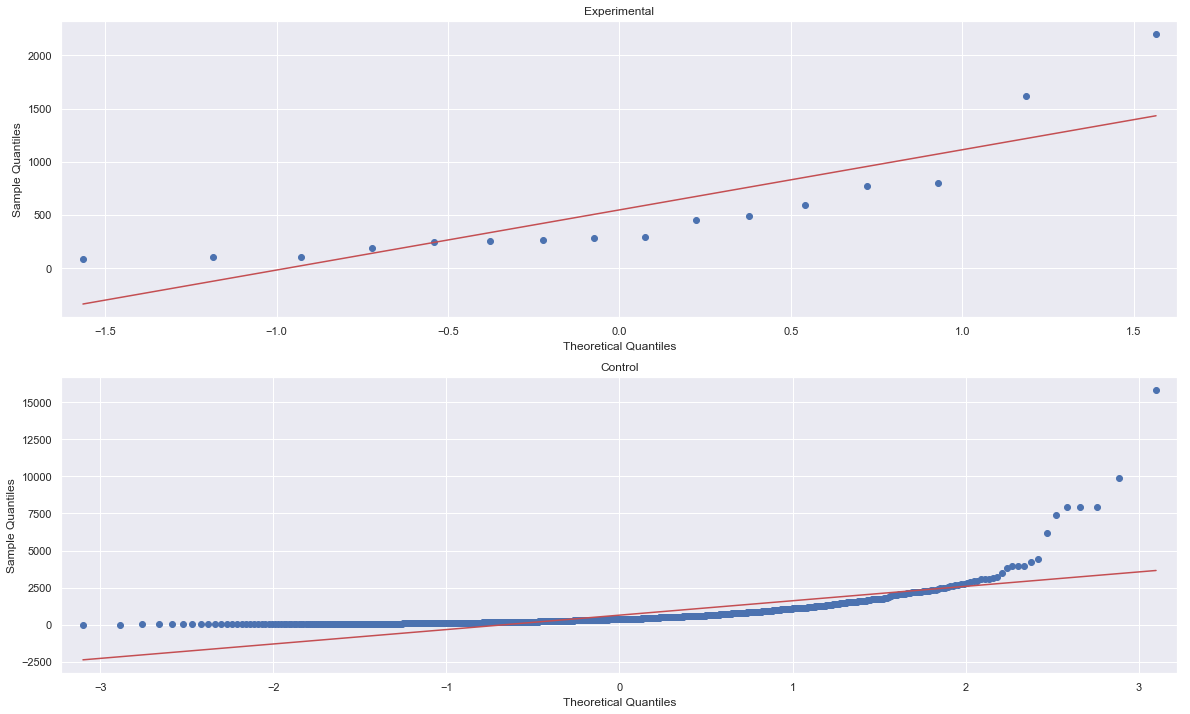

Southern Europe
Statistics=0.130, p=0.896
Cohen's d =  0.011836890955395987
Small Effect
Same distributions (fail to reject H0)
---------------------------------------------


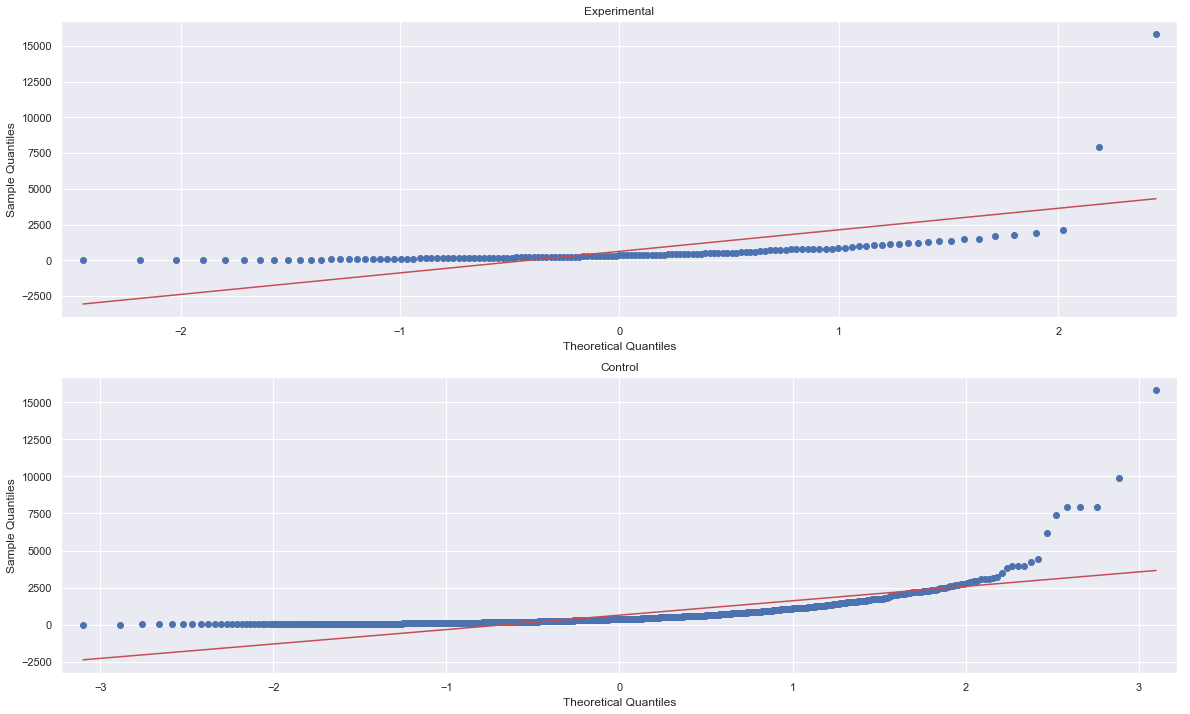

Northern Europe
Statistics=-0.025, p=0.980
Cohen's d =  0.0022496703980056532
Small Effect
Same distributions (fail to reject H0)
---------------------------------------------


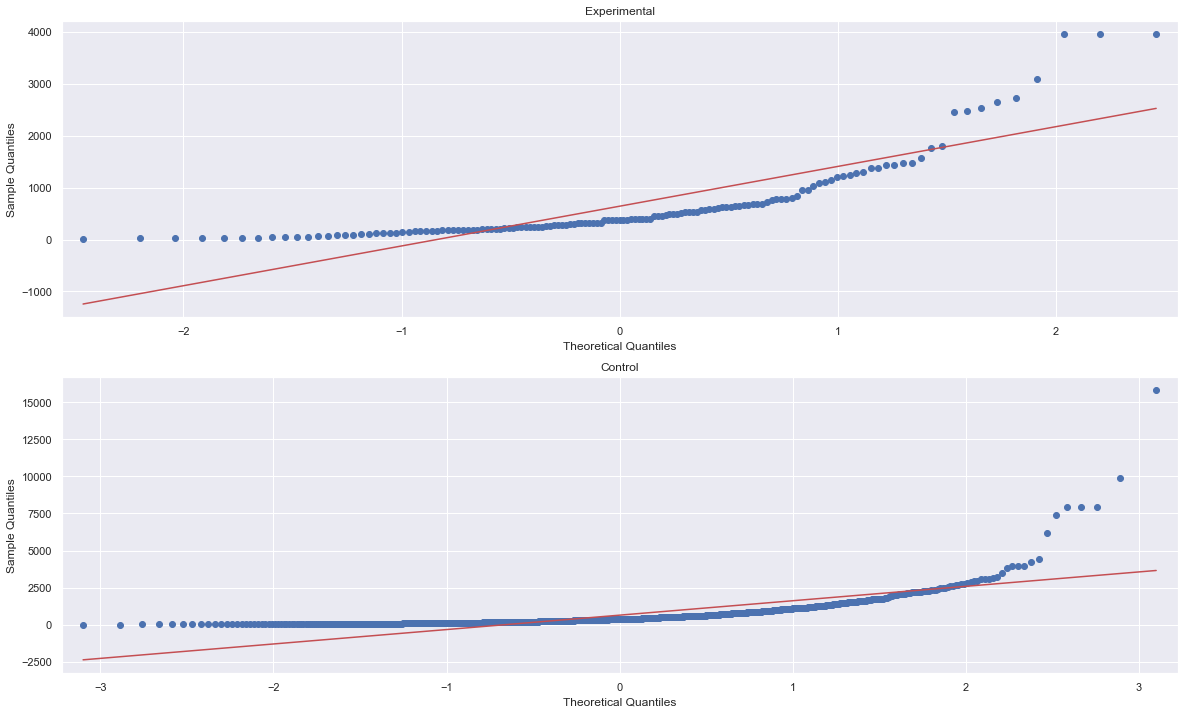

In [1404]:
# Create a for loop that will take in each key, value from the regions list, calculate the T-test 
# compared to the average, the cohen's d, interpret the results and create a visualization to 
# check for normality

for key, value in region_list.items():
    # T-test
    st, p = stats.ttest_ind(controlq3, value)
    print(key)
    print('Statistics=%.3f, p=%.3f' % (st, p))
    
    # Cohen's d
    Cohen_d(controlq3, value)
    
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Same distributions (fail to reject H0)')
    else:
        print('Different distributions (reject H0)')
    print('---------------------------------------------')
    
    # Visualization
    normal_visualization2(controlq3, value)

## Analysis 3:

- p values all greater than the alpha value (0.05) result in no significant difference in average sales price in individual European regions.
- It is clear that Western Europe has the most business, with sales totals being higher than all other regions combined. 
- Cohen's d shows a small effect among samples.

## Conclusion 3:

The results of this experiment lead to an acceptance of the null hypothesis in that there is no difference in average price of each individual sale amoung the European regions.

# -----------------------------------------------------------------------------------------

## Question 4:

Do the amount of territories an employee oversees have an effect on quantity?

## Hypothesis 4:

#### Null:

The amount of territories an employee oversees does not have an effect on quantity of sale. 

#### Alternative:

The amount of territories an employee oversees does have an impact on quantity.


## Data 4:

In [1405]:
# Pull down necessary information

cur.execute("""SELECT * FROM Employee AS e
               JOIN EmployeeTerritory AS et
               on e.Id = et.EmployeeId
               JOIN Territory AS t
               on et.TerritoryId = t.Id
               JOIN [Order]
               on [Order].EmployeeId = e.Id
               JOIN [OrderDetail]
               on [Order].Id = [OrderDetail].OrderId;""")

dfq4 = pd.DataFrame(cur.fetchall())
dfq4.columns = [i[0] for i in cur.description]
dfq4 = dfq4[['Quantity', 'TerritoryId', 'EmployeeId']]

# Remove duplicated columns
column_numbers = [x for x in range(dfq4.shape[1])]  # list of columns' integer indices
column_numbers.remove(2) #removing column integer index 0
dfq4 = dfq4.iloc[:, column_numbers] #return all columns except the 0th column
dfq4.head()

,Quantity,TerritoryId,EmployeeId
0,12,02903,5
1,12,07960,5
2,12,08837,5
3,12,10019,5
4,12,10038,5


In [1406]:
# Create variables that will hold show the number of territories covered by each employee

emp1_terr = dfq4[dfq4['EmployeeId']==1]['TerritoryId'].unique().shape[0]
emp2_terr = dfq4[dfq4['EmployeeId']==2]['TerritoryId'].unique().shape[0]
emp3_terr = dfq4[dfq4['EmployeeId']==3]['TerritoryId'].unique().shape[0]
emp4_terr = dfq4[dfq4['EmployeeId']==4]['TerritoryId'].unique().shape[0]
emp5_terr = dfq4[dfq4['EmployeeId']==5]['TerritoryId'].unique().shape[0]
emp6_terr = dfq4[dfq4['EmployeeId']==6]['TerritoryId'].unique().shape[0]
emp7_terr = dfq4[dfq4['EmployeeId']==7]['TerritoryId'].unique().shape[0]
emp8_terr = dfq4[dfq4['EmployeeId']==8]['TerritoryId'].unique().shape[0]
emp9_terr = dfq4[dfq4['EmployeeId']==9]['TerritoryId'].unique().shape[0]

In [1407]:
# Num of Territories:
# 2, 7, 4, 3, 7, 5, 10, 4, 7

# High territories will be designated as > 6 (Employee Id's 2, 5, 7, 9)
# Low territories will be designated as < 6 (Employee Id's 1, 3, 4, 6, 8)

In [1409]:
# Create a separate data frame for employees with more than 6 territories

df_high_terr1 = dfq4.loc[(dfq4['EmployeeId'] == 2)]
df_high_terr2 = dfq4.loc[(dfq4['EmployeeId'] == 5)]
df_high_terr3 = dfq4.loc[(dfq4['EmployeeId'] == 7)]
df_high_terr4 = dfq4.loc[(dfq4['EmployeeId'] == 9)]

df_high_terr = pd.concat([df_high_terr1, df_high_terr2, df_high_terr3, df_high_terr4])

In [1410]:
# Create a separate data frame for employees with less than 6 territories

df_low_terr1 = dfq4.loc[(dfq4['EmployeeId'] == 1)]
df_low_terr2 = dfq4.loc[(dfq4['EmployeeId'] == 3)]
df_low_terr3 = dfq4.loc[(dfq4['EmployeeId'] == 4)]
df_low_terr4 = dfq4.loc[(dfq4['EmployeeId'] == 6)]
df_low_terr5 = dfq4.loc[(dfq4['EmployeeId'] == 8)]

df_low_terr = pd.concat([df_low_terr1, df_low_terr2, df_low_terr3, df_low_terr4, df_low_terr5])

In [1411]:
experimentalq4 = df_high_terr['Quantity']
controlq4 = df_low_terr['Quantity']

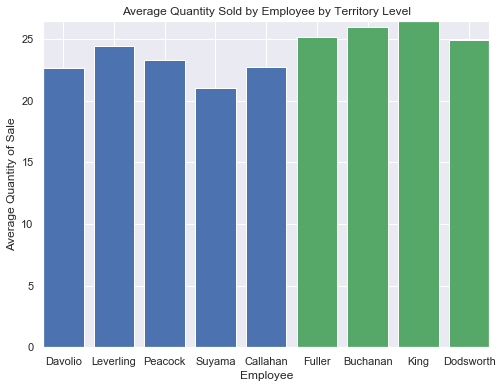

In [1413]:
# Create visualization to compare employees average quantity of sale within each group
ax = plt.subplot(111)

# Create variables to utilize the names list to identify employee
x1 = [e1name.unique()[0], e3name.unique()[0], e4name.unique()[0], e6name.unique()[0], e8name.unique()[0]]
y1 = [np.mean(df_low_terr1['Quantity']), np.mean(df_low_terr2['Quantity']), np.mean(df_low_terr3['Quantity']), np.mean(df_low_terr4['Quantity']), np.mean(df_low_terr5['Quantity'])]
x2 = [e2name.unique()[0], e5name.unique()[0], e7name.unique()[0], e9name.unique()[0]]
y2 = [np.mean(df_high_terr1['Quantity']), np.mean(df_high_terr2['Quantity']), np.mean(df_high_terr3['Quantity']), np.mean(df_high_terr4['Quantity'])]

ax.bar(x1, y1, color='b', align='center')
ax.bar(x2, y2, color='g', align='center')
ax.autoscale(tight=True)

# set labels
plt.title('Average Quantity Sold by Employee by Territory Level')
plt.xlabel('Employee')
plt.ylabel('Average Quantity of Sale')
plt.show()

In [1126]:
np.mean(experimentalq4)

25.696311066799602

In [1127]:
np.mean(controlq4)

23.017794290183808

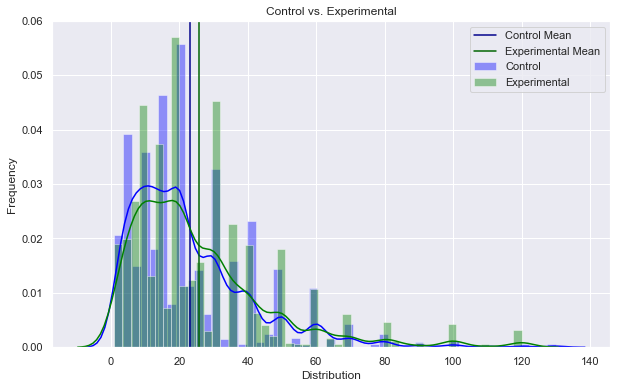

In [1192]:
visualization(controlq4, experimentalq4)

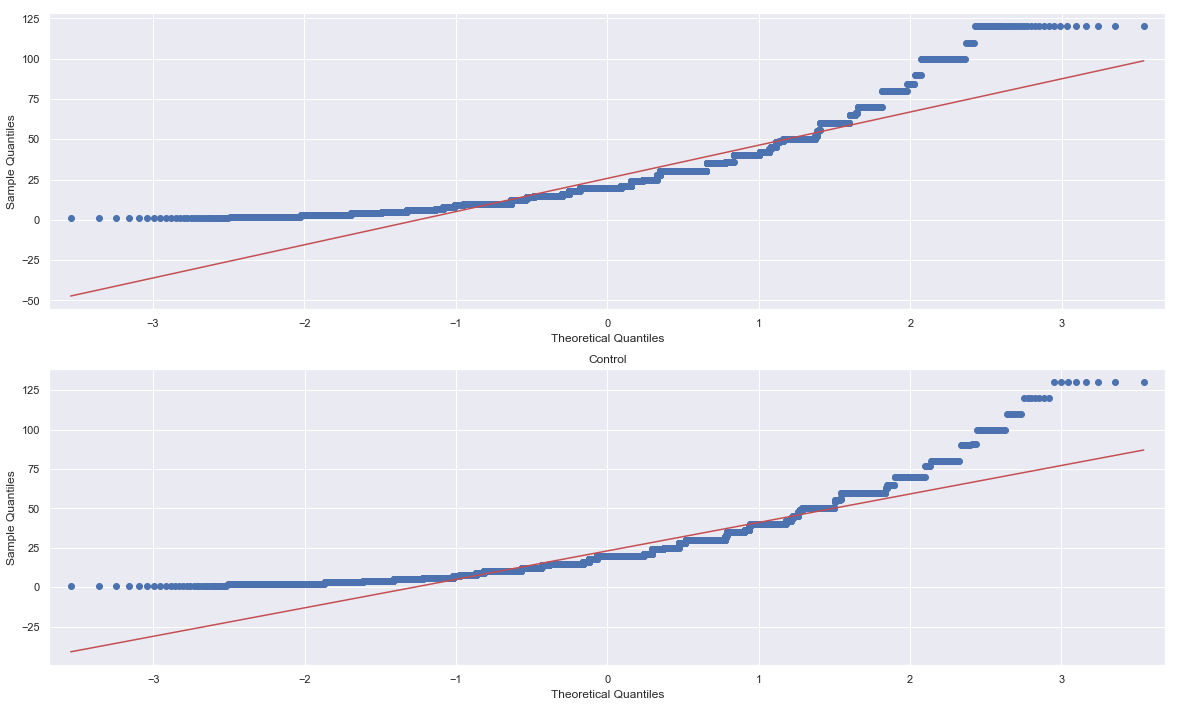

In [1129]:
normal_visualization(controlq4, experimentalq4)

## Experiment 4:

In [1414]:
# Two sample T-test

st, p = stats.ttest_ind(controlq4, experimentalq4)
print('T Stat = %.3f, p = %.3f' % (st, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')
print('---------------------------------------------')

Cohen_d(controlq4, experimentalq4)

T Stat = -6.960, p = 0.000
Different distributions (reject H0)
---------------------------------------------
Cohen's d =  0.13831462752761897
Small Effect


## Analysis 4:

- P value lower than our alpha value
- small effect size

## Conclusion 4:

Reject the null hypothesis, employees with more territories do sell more products.

# -----------------------------------------------------------------------------------------

## Question 5: 

Do certain product categories have more items on backorder than average?

###### Explaination:

In other words, do more dairy products get backordered than average (5.1) due their shorter self-life? In the case of this question, it is assumed that when a customer orders a product and the quantity of that order is larger than the amount of product in stock, the item goes on backorder. This creates a longer chain in processing an order and could potentially take longer for the prodcut to reach the customer (5.2), forcing the company to order the remaining items needed to fill the order from the supplier before filling the customer's order. Finding a significant difference between the average amount of items on backorder and those items on backorder in each individual category, could tell the business more about storage and stocking in the future. 

## Hypothesis 5:

#### Null:

There are no significant difference in the average number of products on backorder and the number of products on backorder in each product category.

#### Alternative:

1 or more product categories have significantly more items on backorder than average. 

## Data 5:

In [1021]:
# Pull data using SQL to include quantity of order and the units in stock at that time. Limit the querry to 
# include only times when the quantity of the order was larger than the amount in stock.

cur.execute("""SELECT * FROM Product
                        JOIN [OrderDetail]
                        on [OrderDetail].ProductId = Product.Id
                        JOIN Category
                        on Category.Id = Product.CategoryId
                        WHERE Quantity > UnitsInStock;""")

dfq5 = pd.DataFrame(cur.fetchall())
dfq5.columns = [i[0] for i in cur.description]
dfq5 = dfq5[['Id', 'ProductName', 'UnitsInStock', 'UnitsOnOrder', 'CategoryName', 'Quantity']]
dfq5['UnitsonBackorder'] = dfq5['Quantity'] - dfq5['UnitsInStock']
dfq5.head()

,Id,Id,Id,ProductName,UnitsInStock,UnitsOnOrder,CategoryName,Quantity,UnitsonBackorder
0,51,10249/51,7,Manjimup Dried Apples,20,0,Produce,40,20
1,51,10250/51,7,Manjimup Dried Apples,20,0,Produce,35,15
2,60,10252/60,4,Camembert Pierrot,19,0,Dairy Products,40,21
3,31,10253/31,4,Gorgonzola Telino,0,70,Dairy Products,20,20
4,49,10253/49,3,Maxilaku,10,60,Confections,40,30


In [940]:
dfq5['CategoryName'].unique()

array(['Produce', 'Dairy Products', 'Confections', 'Beverages',
       'Meat/Poultry', 'Condiments', 'Grains/Cereals', 'Seafood'],
      dtype=object)

In [981]:
controlq5 = backorder_dfq5['UnitsonBackorder']
controlq5_avg = np.mean(backorder_dfq5['UnitsonBackorder'])

In [1022]:
# Create arrays of each product category and the instances of backorder.

dairy = dfq5[dfq5['CategoryName']=='Dairy Products']['UnitsonBackorder']
grains = dfq5[dfq5['CategoryName']=='Grains/Cereals']['UnitsonBackorder']
produce = dfq5[dfq5['CategoryName']=='Produce']['UnitsonBackorder']
seafood = dfq5[dfq5['CategoryName']=='Seafood']['UnitsonBackorder']
condiments = dfq5[dfq5['CategoryName']=='Condiments']['UnitsonBackorder']
confections = dfq5[dfq5['CategoryName']=='Confections']['UnitsonBackorder']
beverages = dfq5[dfq5['CategoryName']=='Beverages']['UnitsonBackorder']

In [1023]:
# Create dicts for averages and sums.

product_list = {'dairy':dairy, 'grains':grains, 'produce':produce, 'seafood':seafood, 'condiments':condiments, 'confections':confections, 'beverages':beverages} 
product_list_mean = {'dairy':np.mean(dairy), 'grains':np.mean(grains), 'produce':np.mean(produce), 'seafood':np.mean(seafood), 'condiments':np.mean(condiments), 'confections':np.mean(confections), 'beverages':np.mean(beverages)}
product_list_sums = {'dairy':np.sum(dairy), 'grains':np.sum(grains), 'produce':np.sum(produce), 'seafood':np.sum(seafood), 'condiments':np.sum(condiments), 'confections':np.sum(confections), 'beverages':np.sum(beverages)}
product_list_valuecounts = {'dairy':dairy.value_counts().sum(), 'grains':dairy.value_counts().sum(), 'produce':dairy.value_counts().sum(), 'seafood':seafood.value_counts().sum(), 'condiments':condiments.value_counts().sum(), 'confections':confections.value_counts().sum(), 'beverages':beverages.value_counts().sum(), 'average':valuecounts_avg} 


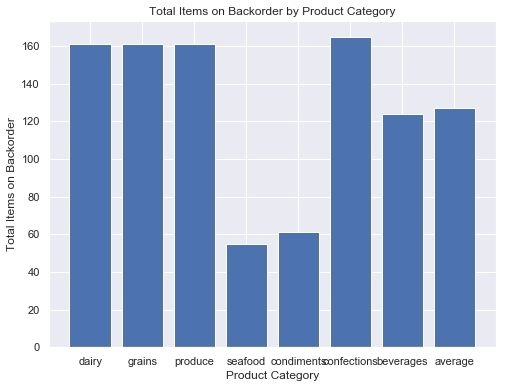

In [1415]:
# Create visualization of products on backorder by category

plt.figure(figsize = (8,6))
plt.bar(range(len(product_list_valuecounts)), list(product_list_valuecounts.values()))
plt.xticks(range(len(product_list_valuecounts)), list(product_list_valuecounts.keys()))

# set labels
plt.title('Total Items on Backorder by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Total Items on Backorder')
plt.show()


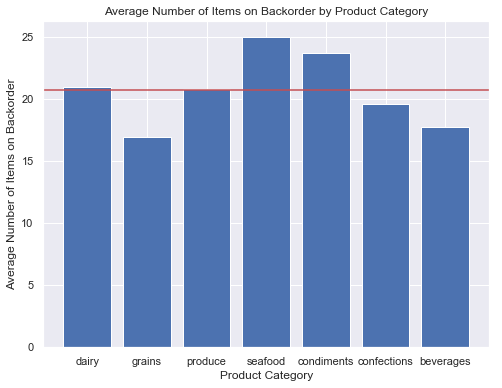

In [1025]:
# bar graph showing the averages
plt.figure(figsize = (8,6))
plt.bar(range(len(product_list_mean)), list(product_list_mean.values()))
plt.xticks(range(len(product_list_mean)), list(product_list_mean.keys()))

# horizontal line indicating the average
plt.axhline(y=controlq5_avg, color='r')

# create labels
plt.title('Average Number of Items on Backorder by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Average Number of Items on Backorder')
plt.show()

## Experiment 5:

###### Test 1: The Kruskal-Wallis H-Test

This test will give an idea of whether there is a difference in the distributions of each cateogry. This non-parametric version of the ANOVA test will show whether there is any significant difference within the categories.

In [1159]:
stat, p = kruskal(dairy, grains, produce, seafood, condiments, confections, beverages)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')
print('---------------------------------------------')

Statistics=13.543, p=0.035
Different distributions (reject H0)
---------------------------------------------


###### Test 2: Two Sided T-test

This test will give an idea of whether each individual product category is significantly different from the mean. Using all items on backorder as the control and comaring that each individual product category mean, we can see break down the differences based on category. 

dairy
T STAT = -0.177, P = 0.859
Same distributions (fail to reject H0)
---------------------------------------------
Cohen's d =  0.015336490900119284
Small Effect


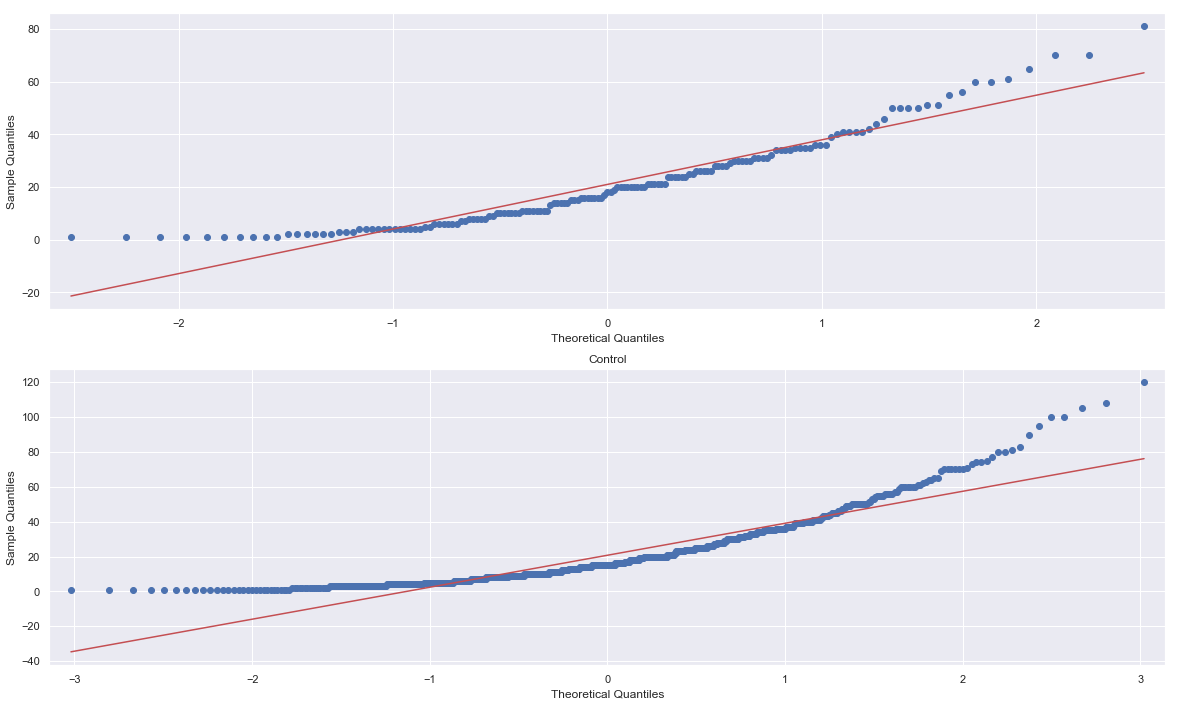

grains
T STAT = 1.456, P = 0.146
Same distributions (fail to reject H0)
---------------------------------------------
Cohen's d =  0.20483799356335547
Medium Effect


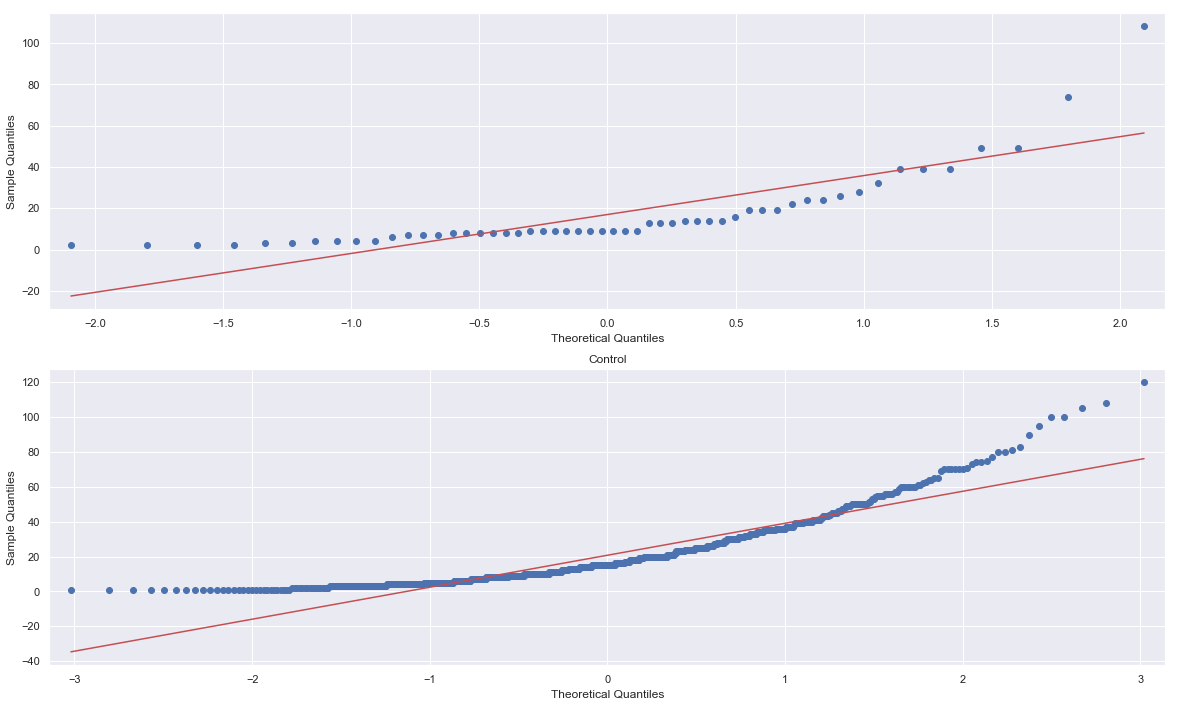

produce
T STAT = -0.024, P = 0.981
Same distributions (fail to reject H0)
---------------------------------------------
Cohen's d =  0.0033773642787220297
Small Effect


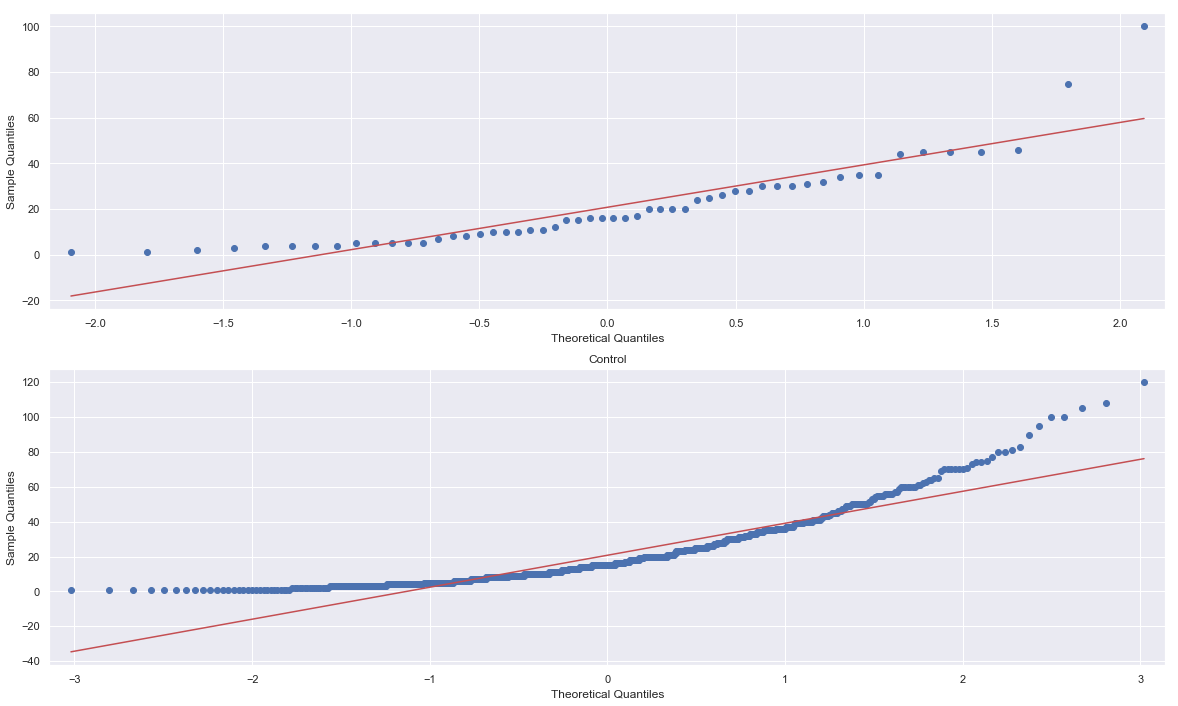

seafood
T STAT = -1.658, P = 0.098
Same distributions (fail to reject H0)
---------------------------------------------
Cohen's d =  0.23117207881763666
Medium Effect


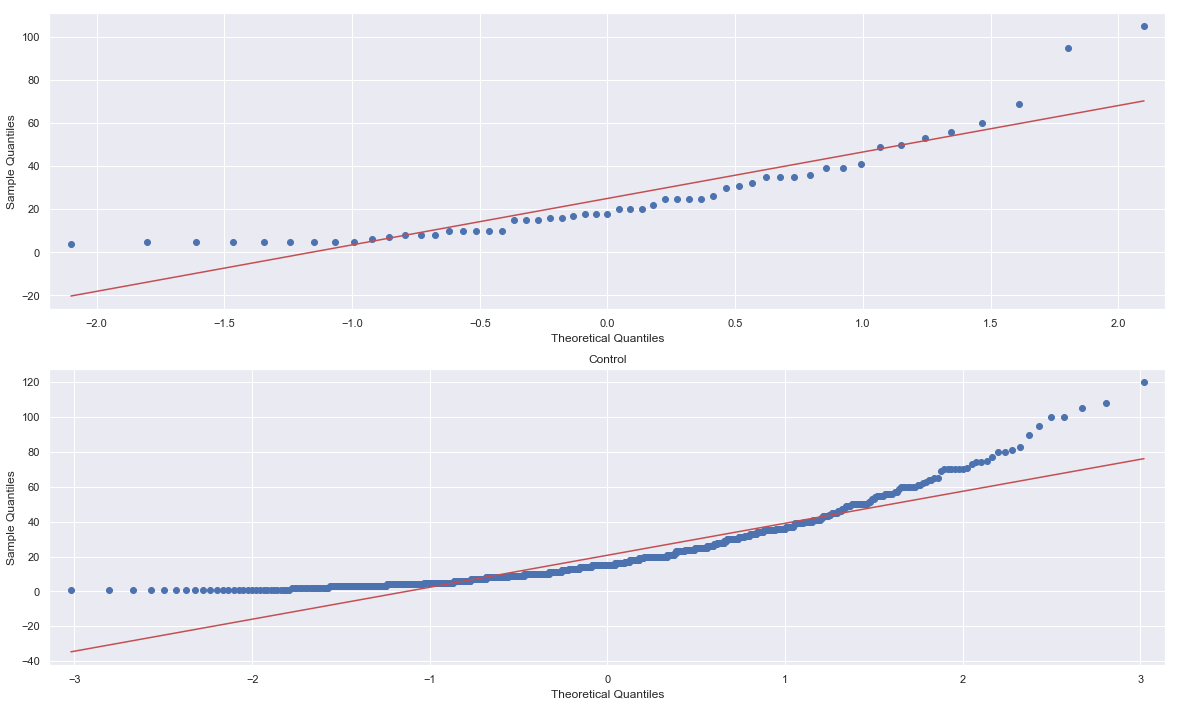

condiments
T STAT = -1.218, P = 0.224
Same distributions (fail to reject H0)
---------------------------------------------
Cohen's d =  0.16179901171124125
Small Effect


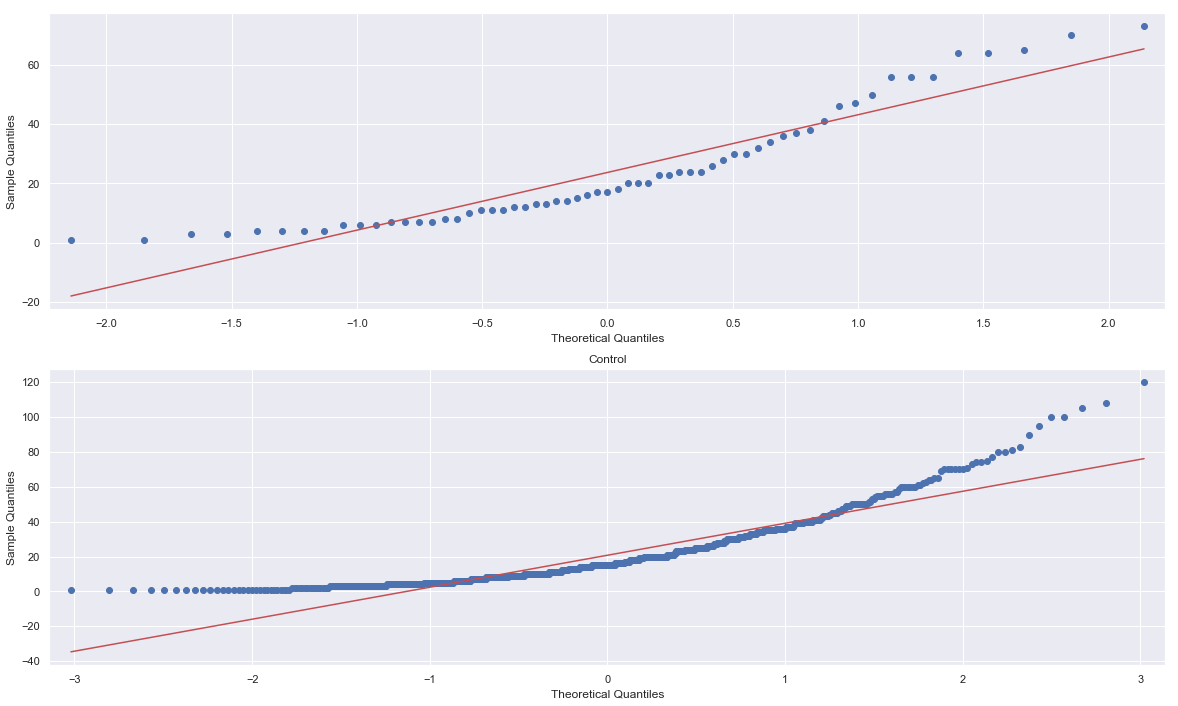

confections
T STAT = 0.748, P = 0.454
Same distributions (fail to reject H0)
---------------------------------------------
Cohen's d =  0.06406666032563892
Small Effect


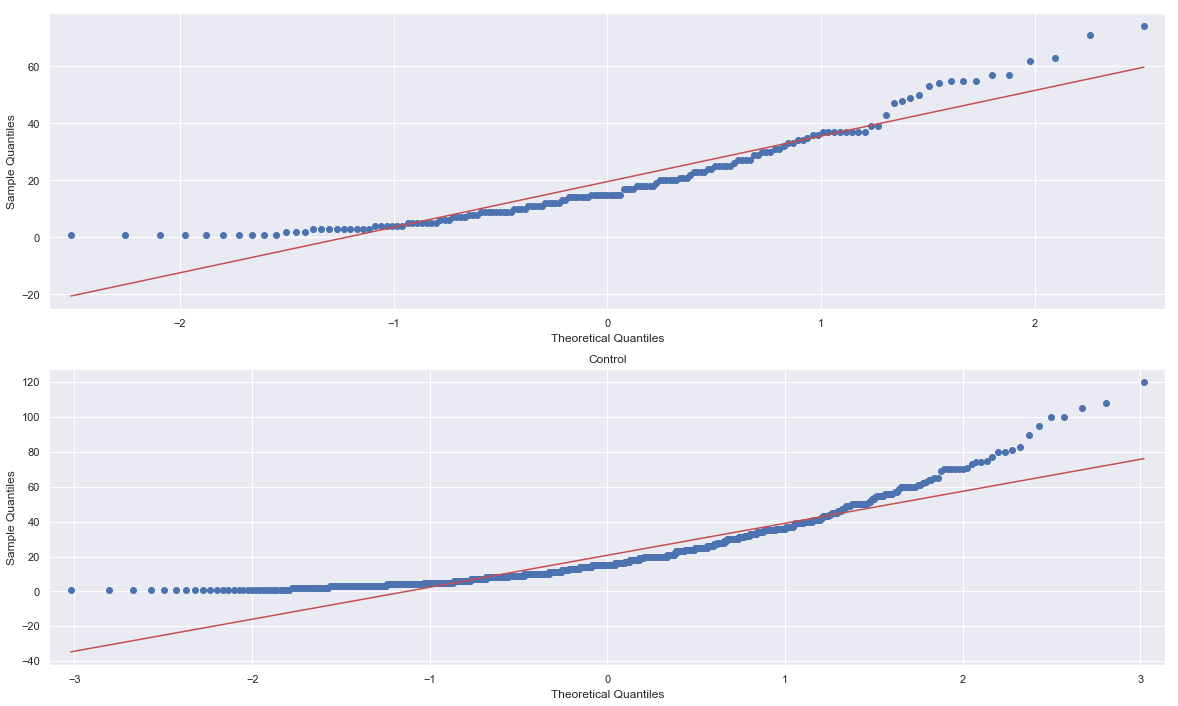

beverages
T STAT = 1.705, P = 0.089
Same distributions (fail to reject H0)
---------------------------------------------
Cohen's d =  0.16470765135400595
Small Effect


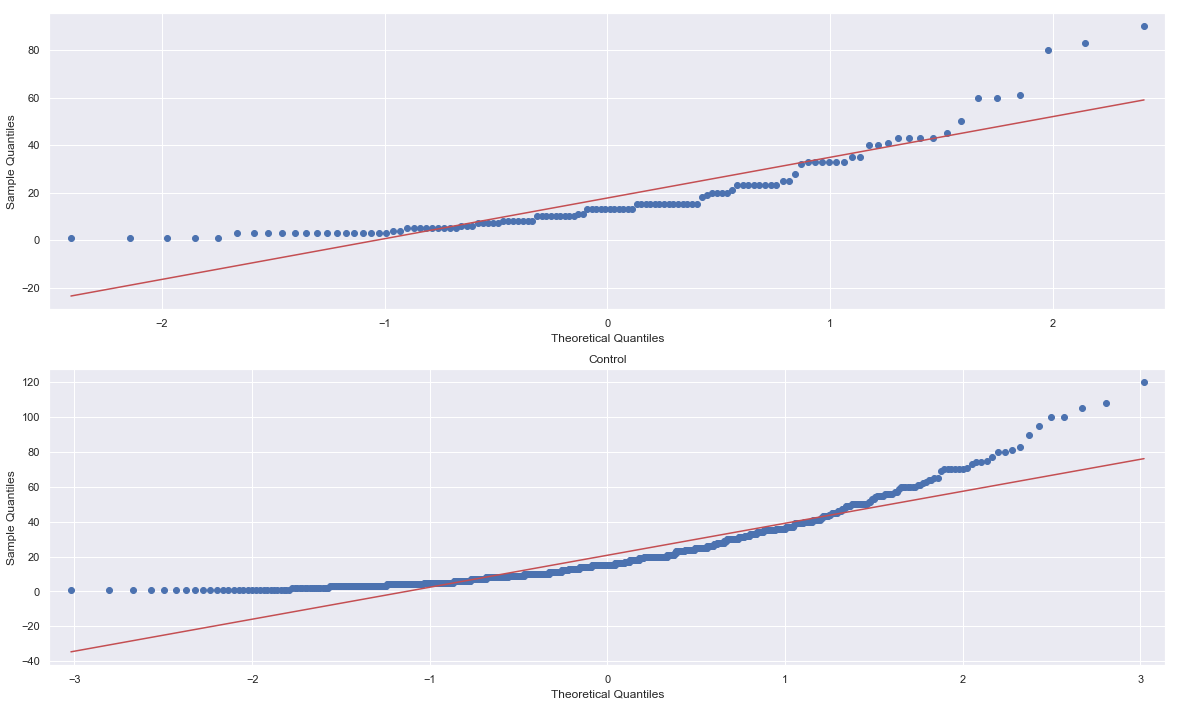

In [1184]:
for key, value in product_list.items():
    st, p = stats.ttest_ind(controlq5, value)

    print(key)
    print('T STAT = %.3f, P = %.3f' % (st, p))

    # interpret
    if p > alpha:
        print('Same distributions (fail to reject H0)')
    else:
        print('Different distributions (reject H0)')
    print('---------------------------------------------')
    d = Cohen_d(controlq5, value)
    normal_visualization2(controlq5, value)

## Analysis 5:

###### Test 1:

The H-test shows us that there are significant differences in the number of items going on back order between categories. There are items that are backordered more or less than others. 

###### Test 2: 

Each T-test has failed to reject the null hypothesis, telling that there is are no significant differences in the number of items that go on backorder by category when compared to the average product. 

## Conclusion 5:

Fail to reject the null. Certain orders do not go on backorder more than the average.

# -----------------------------------------------------------------------------------------

## Question 5.2:

Do items on backorder affect the processing time?

## Hypothesis 5.2:

###### Null:

Processing time for items on backorder is not significantly different from that of items not on backorder.

###### Alternative:

Processing time for items on backorder is significantly different from that of items not on backorder.

## Data 5.2:

In [1416]:
# Create a data frame for all items that have not gone on back order, i.e., Quantity < UnitsInStock

cur.execute("""SELECT * FROM Product
                        JOIN [OrderDetail]
                        on [OrderDetail].ProductId = Product.Id
                        JOIN [Order]
                        on [Order].Id = [OrderDetail].OrderId
                        JOIN Category
                        on Category.Id = Product.CategoryId
                        WHERE Quantity < UnitsInStock;""")

nonbackorder = pd.DataFrame(cur.fetchall())
nonbackorder.columns = [i[0] for i in cur.description]

nonbackorder['OrderDate'] = pd.to_datetime(nonbackorder['OrderDate'])
nonbackorder['ShippedDate'] = pd.to_datetime(nonbackorder['ShippedDate'])
nonbackorder['RequiredDate'] = pd.to_datetime(nonbackorder['RequiredDate'])

nonbackorder['ProcessingTime'] = nonbackorder['ShippedDate'] - nonbackorder['OrderDate']
nonbackorder['ShippingTime'] = nonbackorder['RequiredDate'] - nonbackorder['ShippedDate']
nonbackorder.ShippingTime = nonbackorder.ShippingTime.dt.days
nonbackorder.ProcessingTime = nonbackorder.ProcessingTime.dt.days

nonbackorder.head()


,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued,...,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,Id,CategoryName,Description,ProcessingTime,ShippingTime
0,11,Queso Cabrales,5,4,1 kg pkg.,21.00,22,30,30,0,...,59 rue de l'Abbaye,Reims,Western Europe,51100,France,4,Dairy Products,Cheeses,12.0,16.0
1,42,Singaporean Hokkien Fried Mee,20,5,32 - 1 kg pkgs.,14.00,26,0,0,1,...,59 rue de l'Abbaye,Reims,Western Europe,51100,France,5,Grains/Cereals,"Breads, crackers, pasta, and cereal",12.0,16.0
2,72,Mozzarella di Giovanni,14,4,24 - 200 g pkgs.,34.80,14,0,0,0,...,59 rue de l'Abbaye,Reims,Western Europe,51100,France,4,Dairy Products,Cheeses,12.0,16.0
3,14,Tofu,6,7,40 - 100 g pkgs.,23.25,35,0,0,0,...,Luisenstr. 48,Münster,Western Europe,44087,Germany,7,Produce,Dried fruit and bean curd,5.0,37.0
4,41,Jack's New England Clam Chowder,19,8,12 - 12 oz cans,9.65,85,0,10,0,...,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil,8,Seafood,Seaweed and fish,4.0,24.0


In [1417]:
# Create a data frame for all items that have not gone on back order, i.e., Quantity > UnitsInStock

cur.execute("""SELECT * FROM Product
                        JOIN [OrderDetail]
                        on [OrderDetail].ProductId = Product.Id
                        JOIN [Order]
                        on [Order].Id = [OrderDetail].OrderId
                        JOIN Category
                        on Category.Id = Product.CategoryId
                        WHERE Quantity > UnitsInStock;""")

backorder = pd.DataFrame(cur.fetchall())
backorder.columns = [i[0] for i in cur.description]

backorder['OrderDate'] = pd.to_datetime(test_backorder['OrderDate'])
backorder['ShippedDate'] = pd.to_datetime(test_backorder['ShippedDate'])
backorder['RequiredDate'] = pd.to_datetime(test_backorder['RequiredDate'])

backorder['ProcessingTime'] = backorder['ShippedDate'] - backorder['OrderDate']
backorder['ShippingTime'] = backorder['RequiredDate'] - backorder['ShippedDate']
backorder.ShippingTime = backorder.ShippingTime.dt.days
backorder.ProcessingTime = backorder.ProcessingTime.dt.days

backorder.head()

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued,...,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,Id,CategoryName,Description,ProcessingTime,ShippingTime
0,51,Manjimup Dried Apples,24,7,50 - 300 g pkgs.,53.0,20,0,10,0,...,Luisenstr. 48,Münster,Western Europe,44087,Germany,7,Produce,Dried fruit and bean curd,5.0,37.0
1,51,Manjimup Dried Apples,24,7,50 - 300 g pkgs.,53.0,20,0,10,0,...,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil,7,Produce,Dried fruit and bean curd,4.0,24.0
2,60,Camembert Pierrot,28,4,15 - 300 g rounds,34.0,19,0,0,0,...,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium,4,Dairy Products,Cheeses,2.0,26.0
3,31,Gorgonzola Telino,14,4,12 - 100 g pkgs,12.5,0,70,20,0,...,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil,4,Dairy Products,Cheeses,6.0,8.0
4,49,Maxilaku,23,3,24 - 50 g pkgs.,20.0,10,60,15,0,...,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil,3,Confections,"Desserts, candies, and sweet breads",6.0,8.0


In [1145]:
controlq52 = nonbackorder['ProcessingTime']
experimentalq52 = backorder['ProcessingTime']

In [1146]:
controlq52.mean()

8.268867924528301

In [1147]:
experimentalq52.mean()

8.421733505821475

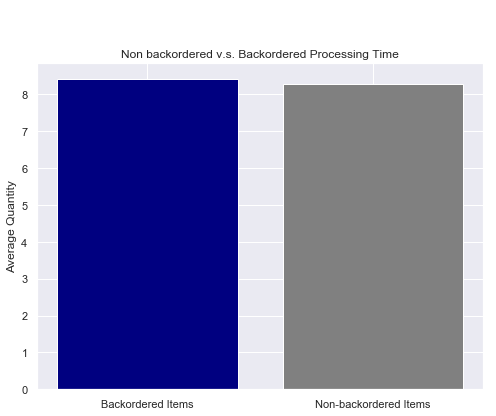

In [1418]:
# Create visualization to compare averages

x = ['Backordered Items', 'Non-backordered Items']
y = [experimentalq52.mean(), controlq52.mean()]
plt.bar(x,y, color=('navy','grey'))
plt.text(s=round(y[1],2), x=1, y=10, color="w", horizontalalignment='center',size=18)
plt.text(s=round(y[0],2), x=0, y=10, color="w", horizontalalignment='center',size=18)
plt.ylabel('Average Quantity')
plt.title('Non backordered v.s. Backordered Processing Time')
plt.show()

## Experiment 5.2:

In [1151]:
stat, p = mannwhitneyu(controlq52, experimentalq52)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=512383.000, p=0.208
Same distribution (fail to reject H0)


## Results:

The means of these distributions are very close together, with a p value of 0.208 being greater than our alpha of 0.05, we can see that these distributions are not statistically different.

## Conclusion:

Fail to reject the null, processing time is no different for orders that go on backorder to orders that are not on backorder.

# -----------------------------------------------------------------------------------------

## Overview of Results and Business Recommendations

* Question 1.1 - Providing a discount does increase the amount of quantity in the order.
* Question 1.2 - The impact of discounts on quantity vary by discount level, with a %5 discount being the most impactful on quantity.
* Recs - Find more opportunities to provide customers with 5% and 15% discounts (ad campaigns, email blasts, customer reward programs)


* Question 2 - There are no significant differences between employees average sales price.
* Recs - Use average sale by employee (628 dollars) as a marker for success, rewarding employees who increase their average over time (commissions, extra PTO, special events)


* Question 3 - There are no significant differences in average sales price between regions.
* Recs - Focus ad campaigns in eastern, northern and southern European regions. Focus on further development western Europe.


* Question 4 - There are significant differences in employee sales quantities depending on territory amounts.
* Recs - Develop young and promising employees by adding sales regions to their responsibilities.


* Question 5.1 - Backordering varies by product, but no one category is backordered more than average.
* Question 5.2 - Items that go on backorder do not significantly impact the average processing time of the order. 
* Recs - Further investigate how often items are backordered for future growth

